In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install causal-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.6/192.6 kB 6.5 MB/s eta 0:00:00


In [26]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.image as mpimg
import io

from causallearn.search.ScoreBased.GES import ges
from causallearn.utils.GraphUtils import GraphUtils
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [5]:
#loading osprey data
osprey_path = '/content/drive/MyDrive/ml_climate_project_data/osprey/'

csv_files = [f for f in os.listdir(osprey_path) if f.endswith('.csv')]

osprey_df = pd.concat(
    [pd.read_csv(os.path.join(osprey_path, file)) for file in sorted(csv_files)],
    ignore_index = True
)

#getting rid of missing / non-numeric values
osprey_df['OBSERVATION COUNT'] = pd.to_numeric(osprey_df['OBSERVATION COUNT'], errors = 'coerce')
osprey_df = osprey_df.dropna(subset = ['OBSERVATION COUNT'])

osprey_df = osprey_df[['OBSERVATION DATE', 'OBSERVATION COUNT', 'COUNTY']]

#display 5 rows
osprey_df.head()

<ipython-input-5-79d17260af50>:7: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  [pd.read_csv(os.path.join(osprey_path, file)) for file in sorted(csv_files)],
<ipython-input-5-79d17260af50>:7: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  [pd.read_csv(os.path.join(osprey_path, file)) for file in sorted(csv_files)],
<ipython-input-5-79d17260af50>:7: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  [pd.read_csv(os.path.join(osprey_path, file)) for file in sorted(csv_files)],
<ipython-input-5-79d17260af50>:7: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  [pd.read_csv(os.path.join(osprey_path, file)) for file in sorted(csv_files)],
<ipython-input-5-79d17260af50>:7: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.


,OBSERVATION DATE,OBSERVATION COUNT,COUNTY
0,1994-01-09,1.0,Los Angeles
1,1994-01-08,1.0,Marin
3,1994-01-13,1.0,Monterey
4,1994-01-17,1.0,Monterey
6,1994-01-15,1.0,Orange


In [6]:
#loading bald_eagle data
eagle_path = '/content/drive/MyDrive/ml_climate_project_data/bald_eagle/'

csv_files = [f for f in os.listdir(eagle_path) if f.endswith('.csv')]
bald_eagle_df = pd.concat(
    [pd.read_csv(os.path.join(eagle_path, file)) for file in sorted(csv_files)],
    ignore_index = True
)

#getting rid of missing / non-numeric values
bald_eagle_df['OBSERVATION COUNT'] = pd.to_numeric(bald_eagle_df['OBSERVATION COUNT'], errors = 'coerce')
bald_eagle_df = bald_eagle_df.dropna(subset = ['OBSERVATION COUNT'])

bald_eagle_df = bald_eagle_df[['OBSERVATION DATE', 'OBSERVATION COUNT', 'COUNTY']]

#displaying 5 rows
bald_eagle_df.head()

,OBSERVATION DATE,OBSERVATION COUNT,COUNTY
0,1994-01-09,1.0,Del Norte
1,1994-01-04,1.0,Del Norte
2,1994-01-16,1.0,Del Norte
3,1994-01-09,1.0,Del Norte
4,1994-01-20,2.0,Del Norte


In [7]:
#fish data
fish_df = pd.read_csv('/content/drive/MyDrive/ml_climate_project_data/fishdata.csv')

#temperature data
temp_df = pd.read_csv('/content/drive/MyDrive/ml_climate_project_data/tempdata.csv')

temp_df = temp_df[temp_df['Anomaly'] != -999]

temp_df['year'] = temp_df['Date'].astype(str).str[:4].astype(int)
temp_df['month'] = temp_df['Date'].astype(str).str[4:].astype(int)

In [8]:
#combine and join data
osprey_df["bird_type"] = "Osprey"
bald_eagle_df["bird_type"] = "Bald Eagle"
bird_df = pd.concat([osprey_df, bald_eagle_df], ignore_index = True)

bird_df['OBSERVATION DATE'] = pd.to_datetime(bird_df['OBSERVATION DATE'])
bird_df['year'] = bird_df['OBSERVATION DATE'].dt.year
bird_df['month'] = bird_df['OBSERVATION DATE'].dt.month

#combine with temperature data
bird_temp_df = bird_df.merge(temp_df[['year', 'month', 'Anomaly']], on=['year', 'month'], how='left')

#combine with fish data
combined_df = bird_temp_df.merge(fish_df, on='year', how='left')
final_df = combined_df.dropna()
final_df = final_df.rename(columns={
    "Anomaly": "temperature",
    "OBSERVATION COUNT": "bird_count",
    "Fish_Population": "fish_population",
})
print(final_df.head(10))

   OBSERVATION DATE  bird_count       COUNTY bird_type  year  month  \
0        1994-01-09         1.0  Los Angeles    Osprey  1994      1   
2        1994-01-09         1.0  Los Angeles    Osprey  1994      1   
3        1994-01-09         1.0  Los Angeles    Osprey  1994      1   
4        1994-01-09         1.0  Los Angeles    Osprey  1994      1   
12       1994-01-09         1.0  Los Angeles    Osprey  1994      1   
13       1994-01-09         1.0  Los Angeles    Osprey  1994      1   
14       1994-01-09         1.0  Los Angeles    Osprey  1994      1   
15       1994-01-09         1.0  Los Angeles    Osprey  1994      1   
19       1994-01-09         1.0  Los Angeles    Osprey  1994      1   
36       1994-01-09         1.0  Los Angeles    Osprey  1994      1   

    temperature  Unnamed: 0    species      spawners       runsize  
0          0.89        12.0    Chinook  6.491291e+04  1.939712e+05  
2          0.89       104.0    Chinook  9.743200e+04  1.125201e+05  
3          

In [9]:
#data setup

final_df['interaction_temp_osprey'] = final_df['temperature'] * (final_df['bird_type'] == 'Osprey').astype(int)
final_df['interaction_temp_bald_eagle'] = final_df['temperature'] * (final_df['bird_type'] == 'Bald Eagle').astype(int)
final_df['interaction_fish_osprey'] = final_df['runsize'] * (final_df['bird_type'] == 'Osprey').astype(int)
final_df['interaction_fish_bald_eagle'] = final_df['runsize'] * (final_df['bird_type'] == 'Bald Eagle').astype(int)

features = ['temperature', 'runsize', 'interaction_temp_osprey', 'interaction_temp_bald_eagle',
            'interaction_fish_osprey', 'interaction_fish_bald_eagle']
target = 'bird_count'
X = final_df[features].values
y = final_df[target].values
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

print(X_tensor.shape)
print(y_tensor.shape)

print(final_df.head(10))

torch.Size([5662717, 6])
torch.Size([5662717, 1])
   OBSERVATION DATE  bird_count       COUNTY bird_type  year  month  \
0        1994-01-09         1.0  Los Angeles    Osprey  1994      1   
2        1994-01-09         1.0  Los Angeles    Osprey  1994      1   
3        1994-01-09         1.0  Los Angeles    Osprey  1994      1   
4        1994-01-09         1.0  Los Angeles    Osprey  1994      1   
12       1994-01-09         1.0  Los Angeles    Osprey  1994      1   
13       1994-01-09         1.0  Los Angeles    Osprey  1994      1   
14       1994-01-09         1.0  Los Angeles    Osprey  1994      1   
15       1994-01-09         1.0  Los Angeles    Osprey  1994      1   
19       1994-01-09         1.0  Los Angeles    Osprey  1994      1   
36       1994-01-09         1.0  Los Angeles    Osprey  1994      1   

    temperature  Unnamed: 0    species      spawners       runsize  \
0          0.89        12.0    Chinook  6.491291e+04  1.939712e+05   
2          0.89       104.0 

In [11]:
#merge data
final_df['OBSERVATION DATE'] = pd.to_datetime(final_df['OBSERVATION DATE'])

monthly_summary = final_df.groupby(['year', 'month', 'bird_type']).agg({
    'bird_count': 'sum',
    'temperature': 'mean',
    'runsize': 'mean',
    'spawners': 'mean'
}).reset_index()

bird_pivot = monthly_summary.pivot_table(index = ['year', 'month'],
                                         columns = 'bird_type',
                                         values = 'bird_count',
                                         fill_value = 0).reset_index()

bird_pivot.columns.name = None
bird_pivot = bird_pivot.rename(columns = {
    'Osprey': 'osprey_count',
    'Bald Eagle': 'bald_eagle_count'
})

temp_fish = monthly_summary.groupby(['year', 'month']).agg({
    'temperature': 'mean',
    'runsize': 'mean',
    'spawners': 'mean'
}).reset_index()

merged_df = pd.merge(bird_pivot, temp_fish, on = ['year', 'month'], how = 'left')
merged_df['interaction'] = merged_df['temperature'] * merged_df['bald_eagle_count']

print(merged_df.head(10))

   year  month  bald_eagle_count  osprey_count  temperature       runsize  \
0  1994      1             165.0         143.0         0.89  2.058768e+06   
1  1994      2             242.0          99.0         0.67  2.058768e+06   
2  1994      3             209.0         286.0         0.75  2.058768e+06   
3  1994      4              44.0         209.0         0.63  2.058768e+06   
4  1994      5              66.0         154.0         0.52  2.058768e+06   
5  1994      6              11.0         132.0         0.50  2.058768e+06   
6  1994      7              11.0         132.0         0.51  2.058768e+06   
7  1994      8              22.0         220.0         0.26  2.058768e+06   
8  1994      9              33.0         396.0         0.46  2.058768e+06   
9  1994     10              33.0         286.0         0.51  2.058768e+06   

        spawners  interaction  
0  470649.146682       146.85  
1  470649.146682       162.14  
2  470649.146682       156.75  
3  470649.146682        

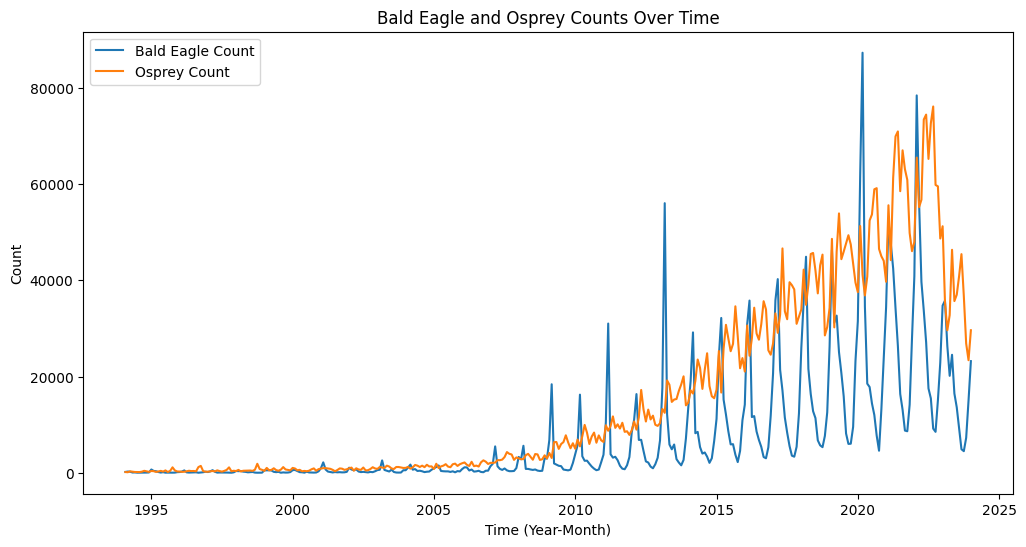

In [12]:
#plotting bald eagle and osprey counts over time (year and month)

plt.figure(figsize = (12, 6))
plt.plot(merged_df['year'] + merged_df['month'] / 12, merged_df['bald_eagle_count'], label = "Bald Eagle Count")
plt.plot(merged_df['year'] + merged_df['month'] / 12, merged_df['osprey_count'], label = "Osprey Count")
plt.xlabel("Time (Year-Month)")
plt.ylabel("Count")
plt.title("Bald Eagle and Osprey Counts Over Time")
plt.legend()
plt.show()

In [13]:
#dag
causal_data = merged_df.drop(columns = ['year', 'month'])
X = causal_data.values
Record = ges(X)

pyd = GraphUtils.to_pydot(Record['G'])
tmp_png = pyd.create_png(f = "png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format = 'png')

#plt.axis('off')
#plt.imshow(img)
#plt.show()
#pyd.write_png('causal_graph.png')

node_labels = [node.get_name() for node in Record['G'].nodes]
print("Node labels:", node_labels)

column_names = causal_data.columns.tolist()
node_to_column_map = dict(zip([f'X{i+1}' for i in range(len(column_names))], column_names))
print("Node to Column Mapping:", node_to_column_map)

target_column = 'bald_eagle_count'

target_node_label = next(label for label, col in node_to_column_map.items() if col == target_column)
node_labels = [node.get_name() for node in Record['G'].nodes]
print("Node labels in the causal graph:", node_labels)

target_column = 'bald_eagle_count'
target_node = None
for node in Record['G'].nodes:
    if node.get_name() == target_node_label:
        target_node = node
        break

if target_node is None:
    print(f"Error: Node '{target_node_label}' not found in the graph.")
else:
    parents_of_target = Record['G'].get_parents(target_node)
    parent_columns = [node_to_column_map[parent.get_name()] for parent in parents_of_target]

nodes = Record['G'].get_nodes()
name_to_node = {node.get_name(): node for node in nodes}

target_node_label = 'X2'
target_node = name_to_node[target_node_label]

parents_of_X2 = Record['G'].get_parents(target_node)

print("Causal edges:")
for edge in Record['G'].get_graph_edges():
    print(f"{edge.get_node1().get_name()} -> {edge.get_node2().get_name()}")


Node labels: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']
Node to Column Mapping: {'X1': 'bald_eagle_count', 'X2': 'osprey_count', 'X3': 'temperature', 'X4': 'runsize', 'X5': 'spawners', 'X6': 'interaction'}
Node labels in the causal graph: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']
Causal edges:
X1 -> X2
X1 -> X6
X2 -> X3
X2 -> X4
X3 -> X6
X5 -> X4
X6 -> X5


In [14]:
#linear regression

X = merged_df['bald_eagle_count']
Y = merged_df['osprey_count']

model = LinearRegression()
model.fit(X.values.reshape(-1, 1), Y)

Y_pred = model.predict(X.values.reshape(-1, 1))

print("R^2:", r2_score(Y, Y_pred))

R^2: 0.45519774055086193


In [15]:
#random forest

model = RandomForestRegressor()
model.fit(X.values.reshape(-1, 1), Y)

Y_pred = model.predict(X.values.reshape(-1, 1))

print("R^2:", r2_score(Y, Y_pred))

R^2: 0.937125042505447


In [16]:
#mlp regressor

model = MLPRegressor(hidden_layer_sizes=(10,), max_iter=1000)
model.fit(X.values.reshape(-1, 1), Y)

Y_pred = model.predict(X.values.reshape(-1, 1))

print("R^2:", r2_score(Y, Y_pred))

R^2: 0.3385215800541982


In [17]:
#temperature and bald eagle interaction

X_temp_be = merged_df[['temperature', 'bald_eagle_count']]
y_interaction = merged_df['interaction']

model_interaction = RandomForestRegressor()
model_interaction.fit(X_temp_be, y_interaction)

merged_df['predicted_interaction'] = model_interaction.predict(X_temp_be)

print("R^2 for interaction:", r2_score(merged_df['interaction'], merged_df['predicted_interaction']))

R^2 for interaction: 0.9925986695858218


In [18]:
#

y_osprey = merged_df['osprey_count']
X_interaction = merged_df[['predicted_interaction']]

model_osprey = RandomForestRegressor()
model_osprey.fit(X_interaction, y_osprey)

merged_df['predicted_osprey'] = model_osprey.predict(X_interaction)

print("R^2 for osprey:", r2_score(merged_df['osprey_count'], merged_df['predicted_osprey']))

R^2 for osprey: 0.960138775457564


In [21]:
#interaction
merged_df["interaction"] = merged_df["bald_eagle_count"] * merged_df["osprey_count"]

In [22]:
#R* rule
merged_df["competition"] = merged_df["bald_eagle_count"] / (merged_df["osprey_count"] + 1)

In [24]:
#testing hypothesis

features = ["runsize", "spawners", "bald_eagle_count", "competition", "temperature"]
X = merged_df[features]
y = merged_df["osprey_count"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("R² Score:", r2_score(y_test, y_pred))

R² Score: 0.8422487867542645


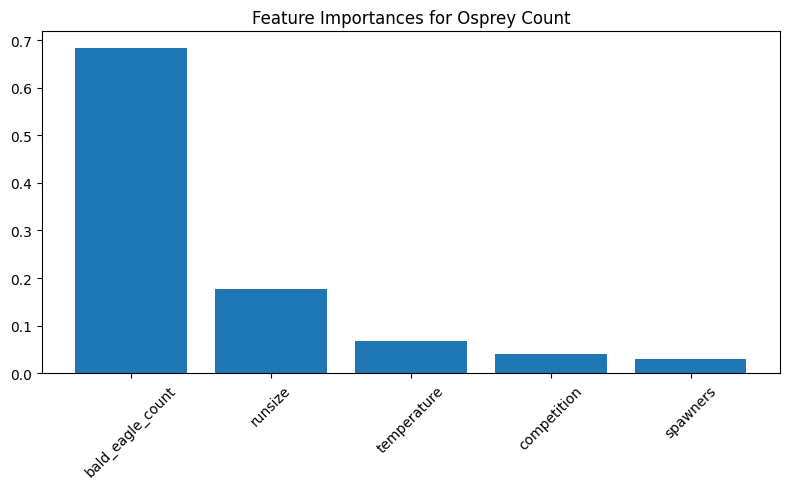

In [27]:
#feature importance

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize = (8, 5))
plt.title("Feature Importances for Osprey Count")
plt.bar(range(len(features)), importances[indices], align = 'center')
plt.xticks(range(len(features)), [features[i] for i in indices], rotation = 45)
plt.tight_layout()
plt.show()

In [31]:
#counterfactuals
avg_runsize = merged_df["runsize"].mean()
avg_spawners = merged_df["spawners"].mean()
avg_temperature = merged_df["temperature"].mean()
avg_bald_eagle_count = merged_df["bald_eagle_count"].mean()

#simulate 2030 conditions (50% fish levels)
scenario_2030 = pd.DataFrame([{
    "runsize": 0.5 * avg_runsize,
    "spawners": 0.5 * avg_spawners,
    "bald_eagle_count": avg_bald_eagle_count,
    "competition": 1,  # still exists
    "temperature": avg_temperature + 1.5  # simulate warming
}])

#predict osprey count
predicted_osprey_2030 = model.predict(scenario_2030)[0]
print(f"Predicted Osprey Count in 2030 under 50% fish: {predicted_osprey_2030:.2f}")


Predicted Osprey Count in 2030 under 50% fish: 24630.92
